In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import matplotlib.pyplot as plt

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

%matplotlib widget

In [2]:
from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis
from LinearMPC_template.MPCVelControl import MPCVelControl

rocket_obj_path     = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path  = os.path.join(parent_dir, "rocket.yaml")

In [3]:
Ts = 1/20
H  = 7.0
Tf = 10.0

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
mpc = MPCVelControl().new_controller(rocket, Ts, H)

xs, us = mpc.xs, mpc.us
print("xs:", xs.shape, "us:", us.shape)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

xs: (12,) us: (4,)


In [4]:
OPEN_STYLE  = dict(linestyle="--", linewidth=2.5, alpha=0.85, marker="o", markersize=3, markevery=10)
CLOSED_STYLE = dict(linestyle="-", linewidth=1.8, alpha=0.95)

def _apply_grid_legend(ax):
    ax.grid(True)
    ax.legend()

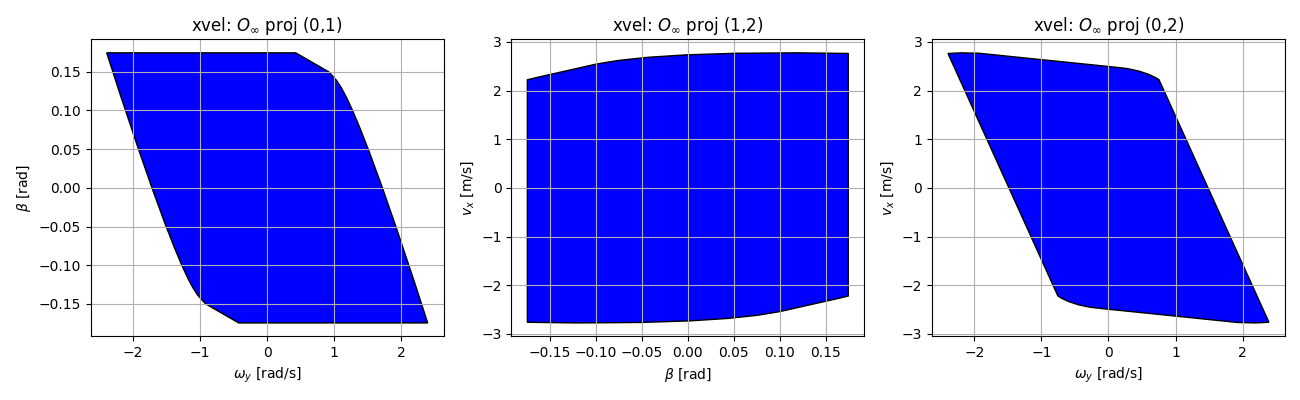

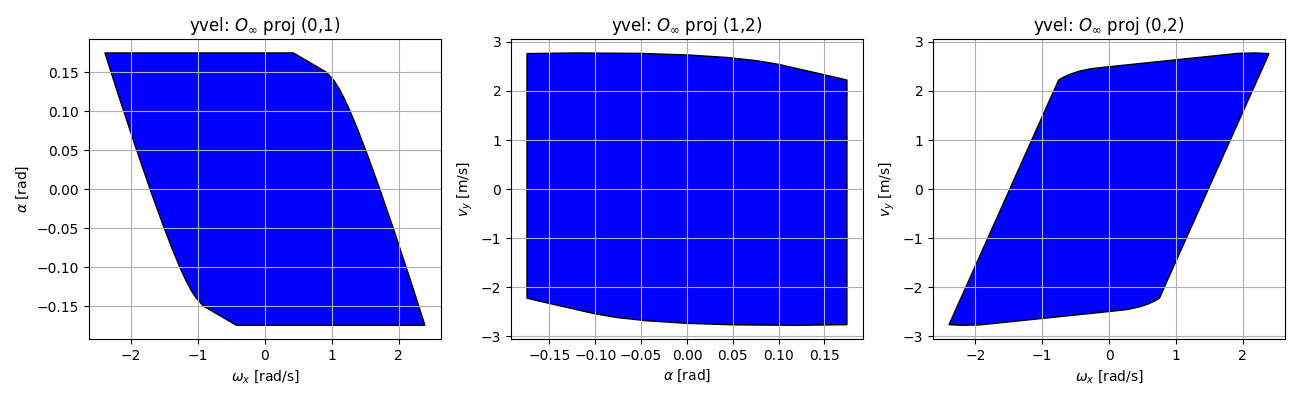

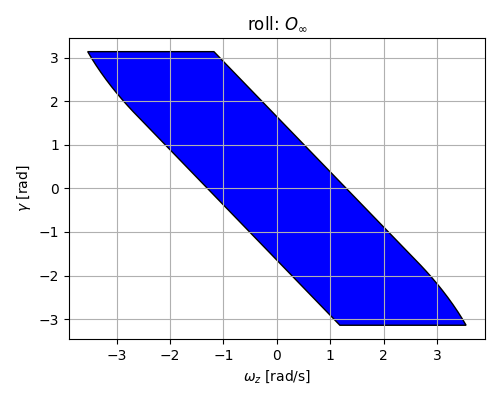

In [5]:
def plot_poly_2d(P, ax=None, title=None, xlabel=None, ylabel=None):
    if ax is None:
        fig, ax = plt.subplots()
    P.plot(ax=ax)
    if title: ax.set_title(title)
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    ax.grid(True)
    return ax

def plot_terminal_sets():
    x_names = [r'$\omega_y$ [rad/s]', r'$\beta$ [rad]', r'$v_x$ [m/s]']
    y_names = [r'$\omega_x$ [rad/s]', r'$\alpha$ [rad]', r'$v_y$ [m/s]']
    r_names = [r'$\omega_z$ [rad/s]', r'$\gamma$ [rad]']

    # XVEL
    Px = mpc.mpc_x.O_inf
    fig, axs = plt.subplots(1, 3, figsize=(13, 4))
    plot_poly_2d(Px.projection(dims=(0,1)), axs[0], "xvel: $O_\\infty$ proj (0,1)", x_names[0], x_names[1])
    plot_poly_2d(Px.projection(dims=(1,2)), axs[1], "xvel: $O_\\infty$ proj (1,2)", x_names[1], x_names[2])
    plot_poly_2d(Px.projection(dims=(0,2)), axs[2], "xvel: $O_\\infty$ proj (0,2)", x_names[0], x_names[2])
    fig.tight_layout()

    # YVEL
    Py = mpc.mpc_y.O_inf
    fig, axs = plt.subplots(1, 3, figsize=(13, 4))
    plot_poly_2d(Py.projection(dims=(0,1)), axs[0], "yvel: $O_\\infty$ proj (0,1)", y_names[0], y_names[1])
    plot_poly_2d(Py.projection(dims=(1,2)), axs[1], "yvel: $O_\\infty$ proj (1,2)", y_names[1], y_names[2])
    plot_poly_2d(Py.projection(dims=(0,2)), axs[2], "yvel: $O_\\infty$ proj (0,2)", y_names[0], y_names[2])
    fig.tight_layout()

    # ROLL
    Pr = mpc.mpc_roll.O_inf
    fig, ax = plt.subplots(figsize=(5, 4))
    plot_poly_2d(Pr, ax, "roll: $O_\\infty$", r_names[0], r_names[1])
    fig.tight_layout()

plot_terminal_sets()

In [6]:
def run_axis_test(axis: str, x0: np.ndarray, sim_method="linear", animate=False):
    # OPEN LOOP
    t0 = 0.0
    u0_ol, x_ol, u_ol, t_ol = mpc.get_u(t0, x0)   # full-state predicted trajectories

    # CLOSED LOOP
    t_cl, x_cl, u_cl, t_ol_hist, x_ol_hist, u_ol_hist, _ = rocket.simulate_control(
        mpc, Tf, H, x0, method=sim_method
    )

    T_h = t_ol[-1]
    idx = np.where(t_cl <= T_h + 1e-12)[0]
    t_cl_h = t_cl[idx]
    t_cl_u = t_cl_h[:-1]

    # PLOTTING
    fig, axs = plt.subplots(3, 1, figsize=(9, 8), sharex=False)
    axs[0].set_title(f"{axis.upper()} — open-loop vs closed-loop ({sim_method})")

    if axis == "x":
        y_ol = x_ol[6, :]
        y_cl = x_cl[6, idx]

        u_ol_i = u_ol[1, :]
        u_cl_i = u_cl[1, :len(t_cl_u)]

        axs[0].plot(t_ol, y_ol, label="vx (open-loop)", **OPEN_STYLE)
        axs[0].plot(t_cl_h, y_cl, label="vx (closed-loop)", **CLOSED_STYLE)
        axs[0].set_ylabel("vx [m/s]")

        axs[1].plot(t_ol[:-1], u_ol_i, label="δ2 (open-loop)", **OPEN_STYLE)
        axs[1].plot(t_cl_u, u_cl_i, label="δ2 (closed-loop)", **CLOSED_STYLE)
        axs[1].set_ylabel("δ2 [rad]")

        axs[2].plot(t_cl_h, y_cl - y_ol[:len(t_cl_h)], label="vx(cl) − vx(ol)")
        axs[2].set_ylabel("Δvx [m/s]")

    elif axis == "y":
        y_ol = x_ol[7, :]
        y_cl = x_cl[7, idx]
        u_ol_i = u_ol[0, :]
        u_cl_i = u_cl[0, :len(t_cl_u)]

        axs[0].plot(t_ol, y_ol, label="vy (open-loop)", **OPEN_STYLE)
        axs[0].plot(t_cl_h, y_cl, label="vy (closed-loop)", **CLOSED_STYLE)
        axs[0].set_ylabel("vy [m/s]")

        axs[1].plot(t_ol[:-1], u_ol_i, label="δ1 (open-loop)", **OPEN_STYLE)
        axs[1].plot(t_cl_u, u_cl_i, label="δ1 (closed-loop)", **CLOSED_STYLE)
        axs[1].set_ylabel("δ1 [rad]")

        axs[2].plot(t_cl_h, y_cl - y_ol[:len(t_cl_h)], label="vy(cl) − vy(ol)")
        axs[2].set_ylabel("Δvy [m/s]")

    elif axis == "z":
        y_ol = x_ol[8, :]
        y_cl = x_cl[8, idx]
        u_ol_i = u_ol[2, :]
        u_cl_i = u_cl[2, :len(t_cl_u)]

        axs[0].plot(t_ol, y_ol, label="vz (open-loop)", **OPEN_STYLE)
        axs[0].plot(t_cl_h, y_cl, label="vz (closed-loop)", **CLOSED_STYLE)
        axs[0].set_ylabel("vz [m/s]")

        axs[1].plot(t_ol[:-1], u_ol_i, label="Pavg (open-loop)", **OPEN_STYLE)
        axs[1].plot(t_cl_u, u_cl_i, label="Pavg (closed-loop)", **CLOSED_STYLE)
        axs[1].set_ylabel("Pavg [%]")

        axs[2].plot(t_cl_h, y_cl - y_ol[:len(t_cl_h)], label="vz(cl) − vz(ol)")
        axs[2].set_ylabel("Δvz [m/s]")

    elif axis == "roll":
        y_ol = x_ol[5, :]
        y_cl = x_cl[5, idx]
        u_ol_i = u_ol[3, :]
        u_cl_i = u_cl[3, :len(t_cl_u)]

        axs[0].plot(t_ol, y_ol, label="γ (open-loop)", **OPEN_STYLE)
        axs[0].plot(t_cl_h, y_cl, label="γ (closed-loop)", **CLOSED_STYLE)
        axs[0].set_ylabel("γ [rad]")

        axs[1].plot(t_ol[:-1], u_ol_i, label="Pdiff (open-loop)", **OPEN_STYLE)
        axs[1].plot(t_cl_u, u_cl_i, label="Pdiff (closed-loop)", **CLOSED_STYLE)
        axs[1].set_ylabel("Pdiff [%]")

        axs[2].plot(t_cl_h, y_cl - y_ol[:len(t_cl_h)], label="γ(cl) − γ(ol)")
        axs[2].set_ylabel("Δγ [rad]")

    axs[2].set_xlabel("t [s]")
    for ax in axs:
        ax.grid(True)
        ax.legend()
    fig.tight_layout()

    # Animation
    if animate:
        vis = RocketVis(rocket, rocket_obj_path)
        vis.anim_rate = 1.0
        vis.animate(t_cl[:-1], x_cl[:, :-1], u_cl, T_ol=t_ol_hist[..., :-1], X_ol=x_ol_hist, U_ol=u_ol_hist)

    return (t_ol, x_ol, u_ol), (t_cl, x_cl, u_cl)

Simulating time 0.00: 
Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
Simulating time 0.25: 
Simulating time 0.30: 
Simulating time 0.35: 
Simulating time 0.40: 
Simulating time 0.45: 
Simulating time 0.50: 
Simulating time 0.55: 
Simulating time 0.60: 
Simulating time 0.65: 
Simulating time 0.70: 
Simulating time 0.75: 
Simulating time 0.80: 
Simulating time 0.85: 
Simulating time 0.90: 
Simulating time 0.95: 
Simulating time 1.00: 
Simulating time 1.05: 
Simulating time 1.10: 
Simulating time 1.15: 
Simulating time 1.20: 
Simulating time 1.25: 
Simulating time 1.30: 
Simulating time 1.35: 
Simulating time 1.40: 
Simulating time 1.45: 
Simulating time 1.50: 
Simulating time 1.55: 
Simulating time 1.60: 
Simulating time 1.65: 
Simulating time 1.70: 
Simulating time 1.75: 
Simulating time 1.80: 
Simulating time 1.85: 
Simulating time 1.90: 
Simulating time 1.95: 
Simulating time 2.00: 
Simulating time 2.05: 
Simulating time 2.10: 
Simulating 

((array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
         0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
         1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
         1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
         2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 ,
         2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15, 3.2 , 3.25,
         3.3 , 3.35, 3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65, 3.7 , 3.75, 3.8 ,
         3.85, 3.9 , 3.95, 4.  , 4.05, 4.1 , 4.15, 4.2 , 4.25, 4.3 , 4.35,
         4.4 , 4.45, 4.5 , 4.55, 4.6 , 4.65, 4.7 , 4.75, 4.8 , 4.85, 4.9 ,
         4.95, 5.  , 5.05, 5.1 , 5.15, 5.2 , 5.25, 5.3 , 5.35, 5.4 , 5.45,
         5.5 , 5.55, 5.6 , 5.65, 5.7 , 5.75, 5.8 , 5.85, 5.9 , 5.95, 6.  ,
         6.05, 6.1 , 6.15, 6.2 , 6.25, 6.3 , 6.35, 6.4 , 6.45, 6.5 , 6.55,
         6.6 , 6.65, 6.7 , 6.75, 6.8 , 6.85, 6.9 , 6.95, 7.  ]),
  array([[-7.28002050e-32, -4.26318

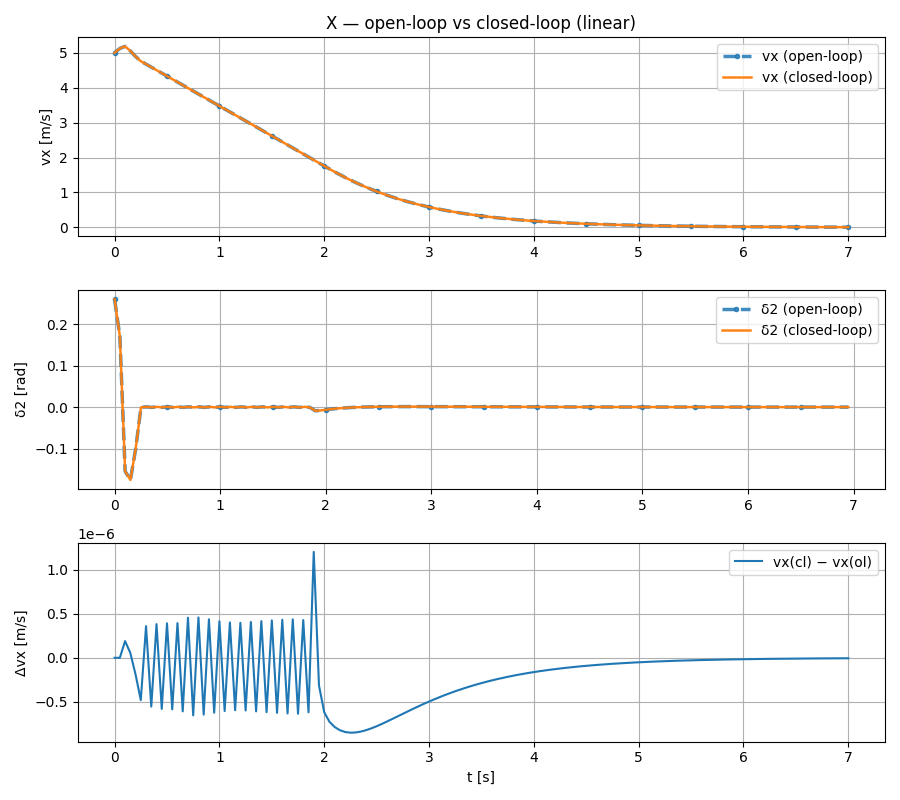

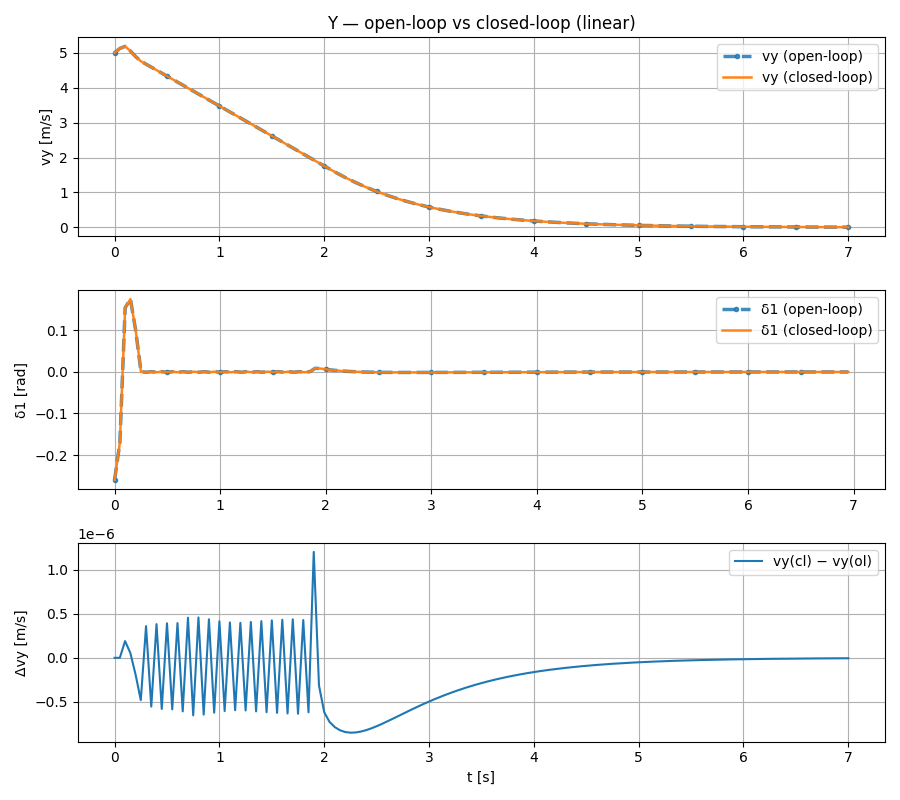

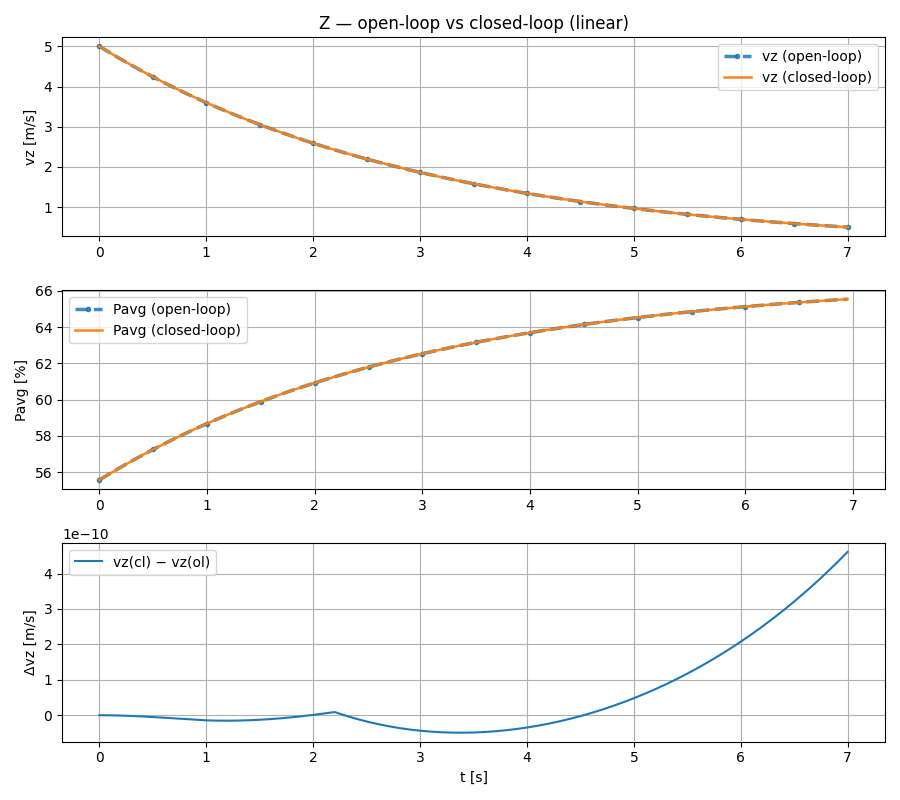

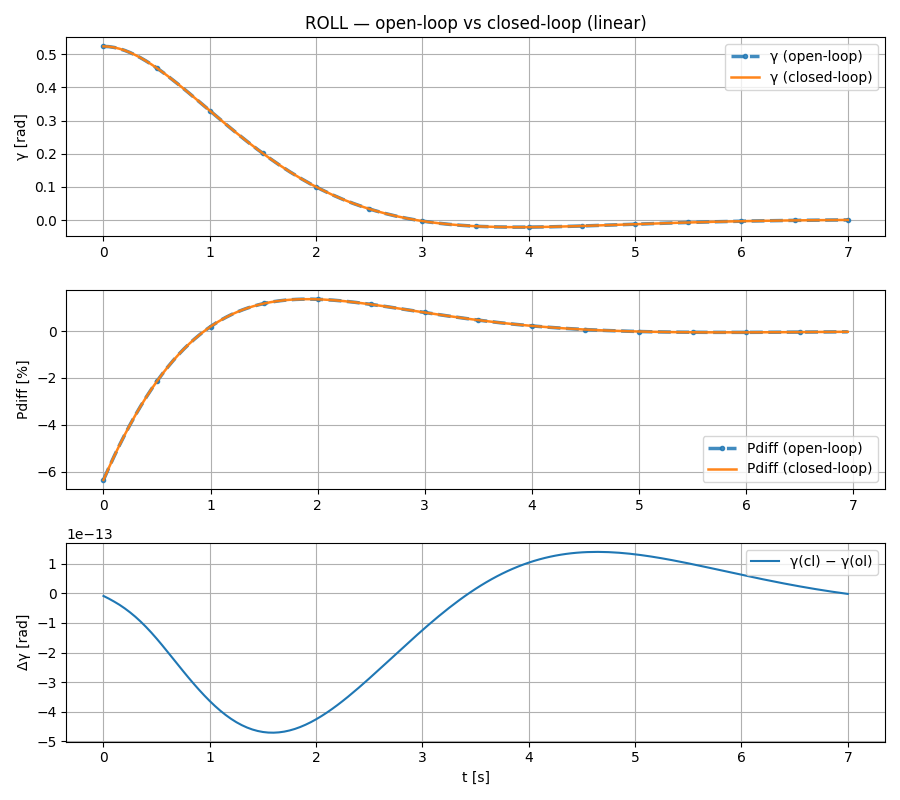

In [7]:
x0_base = xs.copy()

# X
x0_x = x0_base.copy()
x0_x[6] = 5.0
run_axis_test("x", x0_x)

# Y
x0_y = x0_base.copy()
x0_y[7] = 5.0
run_axis_test("y", x0_y)

# Z
x0_z = x0_base.copy()
x0_z[8] = 5.0
run_axis_test("z", x0_z)

# ROLL
x0_r = x0_base.copy()
x0_r[5] = np.deg2rad(30.0)
run_axis_test("roll", x0_r)